In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import kagglehub, os, cv2, re
import numpy as np
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
from tensorflow.keras.optimizers import Adam

data_dir = "/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360"
#data_dir = '/root/.cache/kagglehub/datasets/moltean/fruits/versions/11/fruits-360_dataset_100x100/fruits-360'
training_data = f'{data_dir}/Training'
test_data = f'{data_dir}/Test'
# Lists to store images and labels
images_training = []
labels_training = []
images_test = []
labels_test = []
images_validation = []
labels_validation = []

def resize_images(data, image_var, label_var):
    for subdir, dirs, files in os.walk(data):
        for file in files:
            # Create the image file path
            filepath = os.path.join(subdir, file)

            # Load the image in grayscale
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

            # Resize the image
            image = cv2.resize(image, (64, 64))

            # Append the image and its label to the lists
            image_var.append(image)
            label = os.path.basename(subdir)
            label = re.sub(r'\d+', '', label)
            label_var.append(label)

resize_images(training_data, images_training, labels_training)
resize_images(test_data, images_test, labels_test)

# Combine all images and labels
total_images = images_training + images_test
total_labels = labels_training + labels_test

# Split data into training and temporary sets
images_training, temp_images, labels_training, temp_labels = train_test_split(
    total_images, total_labels, test_size=0.3, random_state=42, stratify=total_labels
)

# Split temporary set into validation and test sets
images_validation, images_test, labels_validation, labels_test = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Convert images to NumPy arrays
images_training_np = np.array(images_training)
images_test_np = np.array(images_test)
images_validation_np = np.array(images_validation)

# Flatten images
images_training_shape = images_training_np.reshape(images_training_np.shape[0], -1)
images_test_shape = images_test_np.reshape(images_test_np.shape[0], -1)
images_validation_shape = images_validation_np.reshape(images_validation_np.shape[0], -1)

# Create and train PCA model
pca = PCA(n_components=0.80)  # Preserve 80% variance
pca.fit(images_training_shape)

# Get transformed data
transformed_images_training = pca.transform(images_training_shape)
transformed_images_test = pca.transform(images_test_shape)
transformed_images_validation = pca.transform(images_validation_shape)

# Normalize data
scaler = MinMaxScaler()
normalized_training = scaler.fit_transform(transformed_images_training)
normalized_test = scaler.transform(transformed_images_test)
normalized_validation = scaler.transform(transformed_images_validation)

# Encode labels
label_encoder = LabelEncoder()
labels_training_encoded = label_encoder.fit_transform(labels_training)
labels_test_encoded = label_encoder.transform(labels_test)
labels_validation_encoded = label_encoder.transform(labels_validation)


# Define machine learning models
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=-1),
    "SVM": SVC()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(normalized_training, labels_training_encoded)

    predictions_test = model.predict(normalized_test)
    predictions_validation = model.predict(normalized_validation)

    # Calculate metrics
    accuracy_test = accuracy_score(labels_test_encoded, predictions_test)
    accuracy_validation = accuracy_score(labels_validation_encoded, predictions_validation)

    precision = precision_score(labels_test_encoded, predictions_test, average='weighted')
    recall = recall_score(labels_test_encoded, predictions_test, average='weighted')
    f1 = f1_score(labels_test_encoded, predictions_test, average='weighted')

    confusion_matrix_var = confusion_matrix(labels_test_encoded, predictions_test)
   

    # Print other metrics
    print(f"{name} - Test Accuracy: {accuracy_test:.4f}")
    print(f"{name} - Validation Accuracy: {accuracy_validation:.4f}")
    print(f"{name} - Precision: {precision:.4f}")
    print(f"{name} - Recall: {recall:.4f}")
    print(f"{name} - F1-score: {f1:.4f}")
    print("-" * 30)

Random Forest - Test Accuracy: 0.9971
Random Forest - Validation Accuracy: 0.9967
Random Forest - Precision: 0.9971
Random Forest - Recall: 0.9971
Random Forest - F1-score: 0.9971
------------------------------
XGBoost - Test Accuracy: 0.9814
XGBoost - Validation Accuracy: 0.9787
XGBoost - Precision: 0.9816
XGBoost - Recall: 0.9814
XGBoost - F1-score: 0.9814
------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LightGBM - Test Accuracy: 0.1473
LightGBM - Validation Accuracy: 0.1510
LightGBM - Precision: 0.1561
LightGBM - Recall: 0.1473
LightGBM - F1-score: 0.1370
------------------------------
SVM - Test Accuracy: 0.9851
SVM - Validation Accuracy: 0.9843
SVM - Precision: 0.9855
SVM - Recall: 0.9851
SVM - F1-score: 0.9850
------------------------------


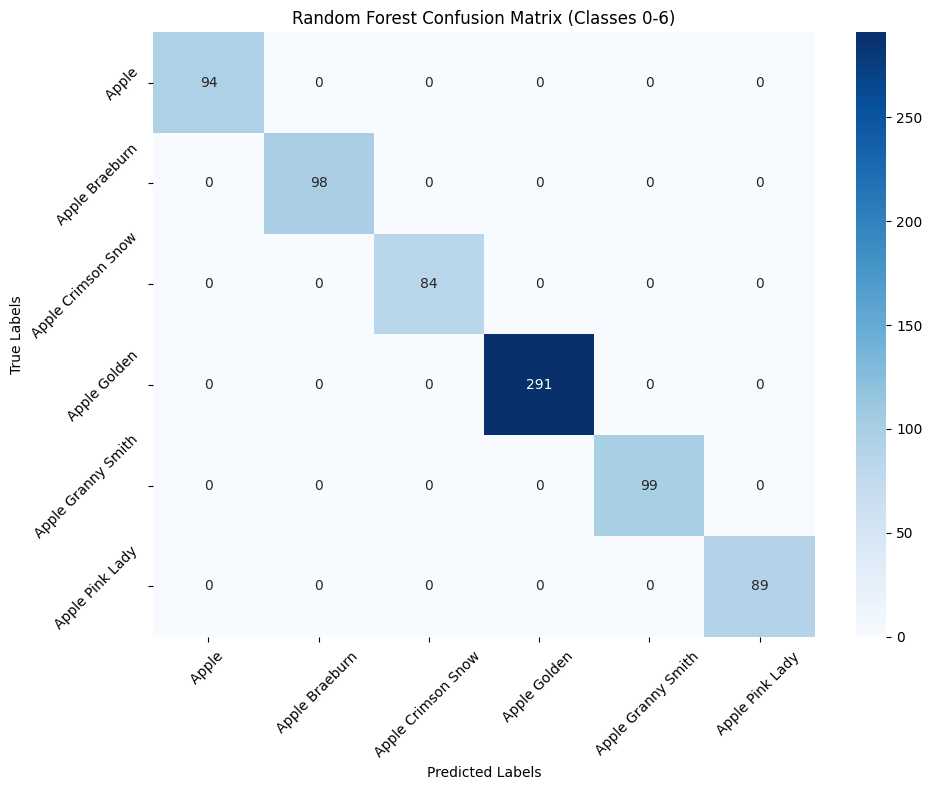

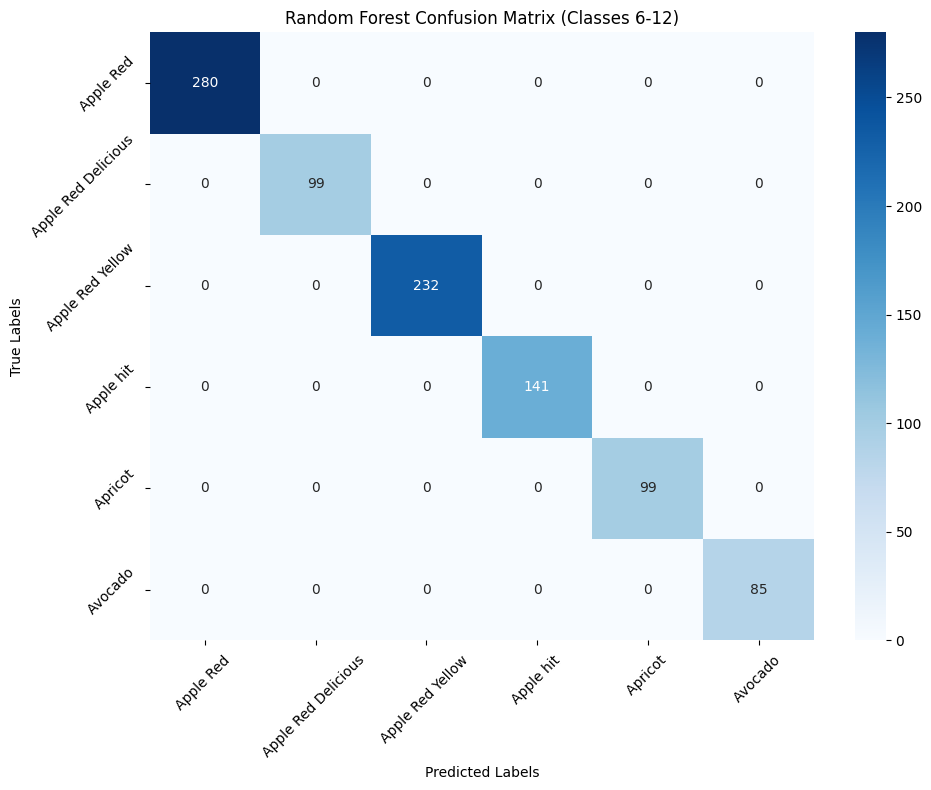

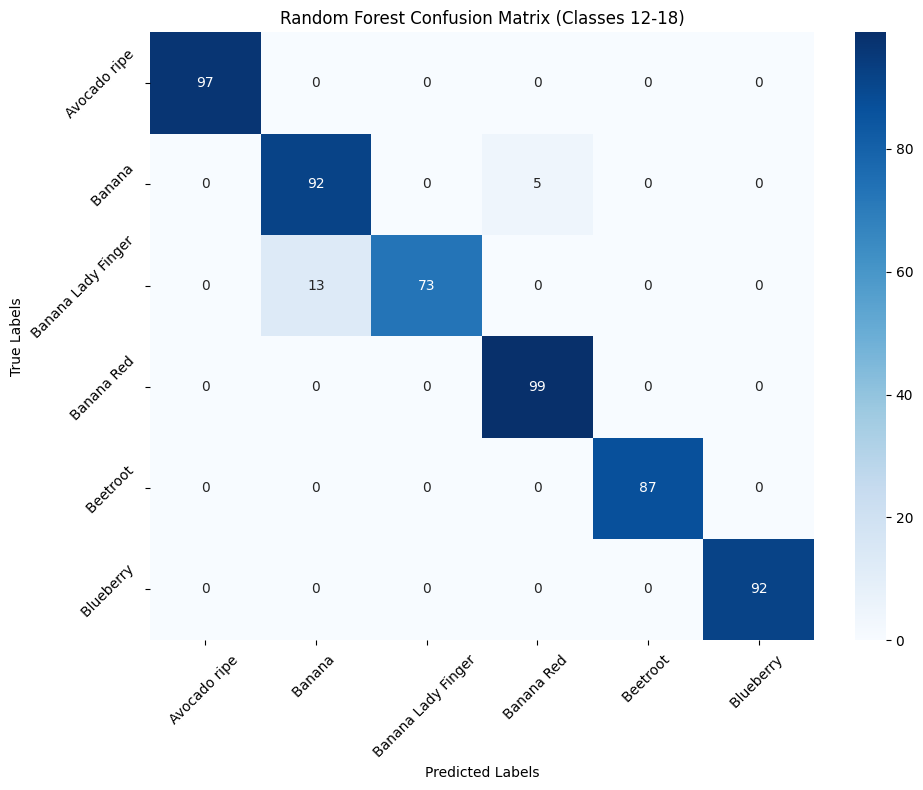

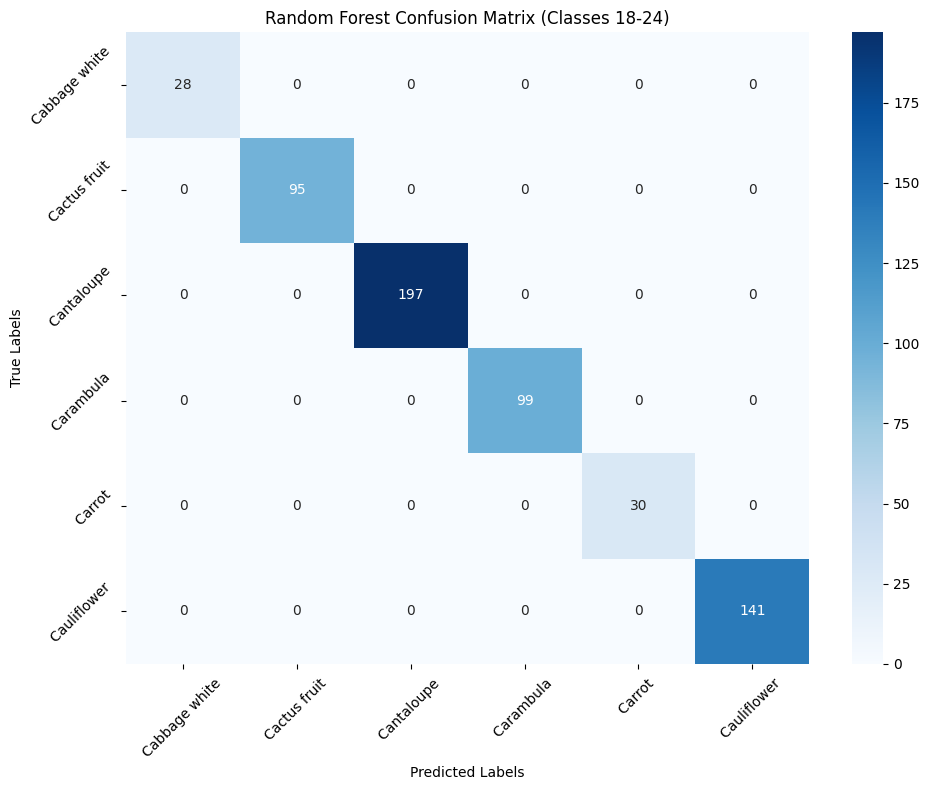

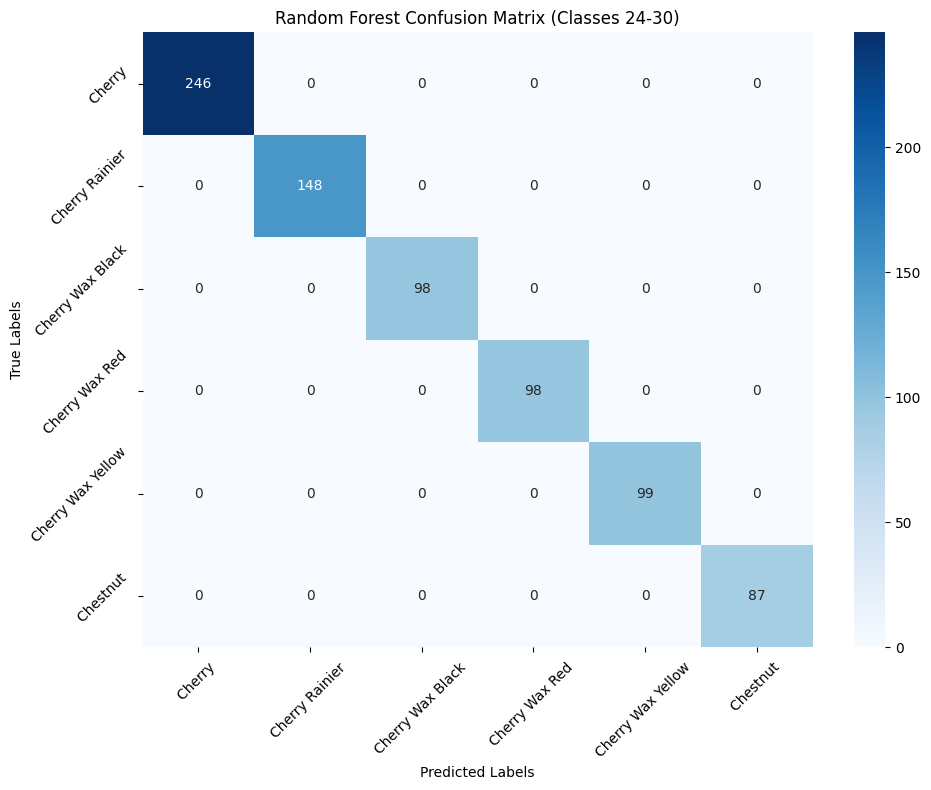

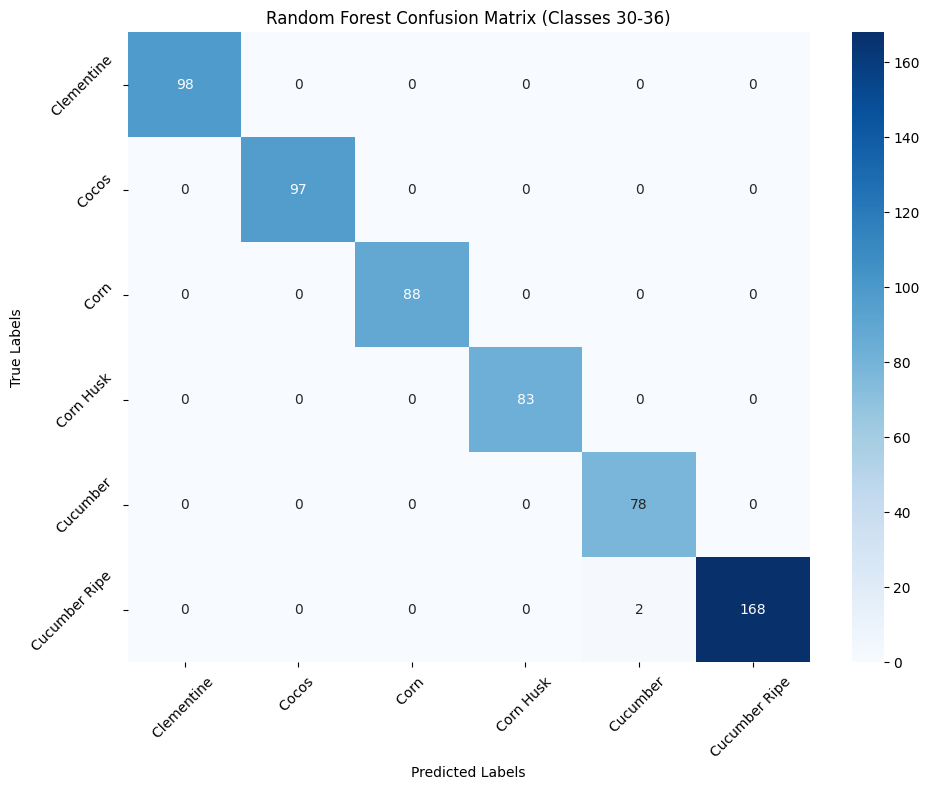

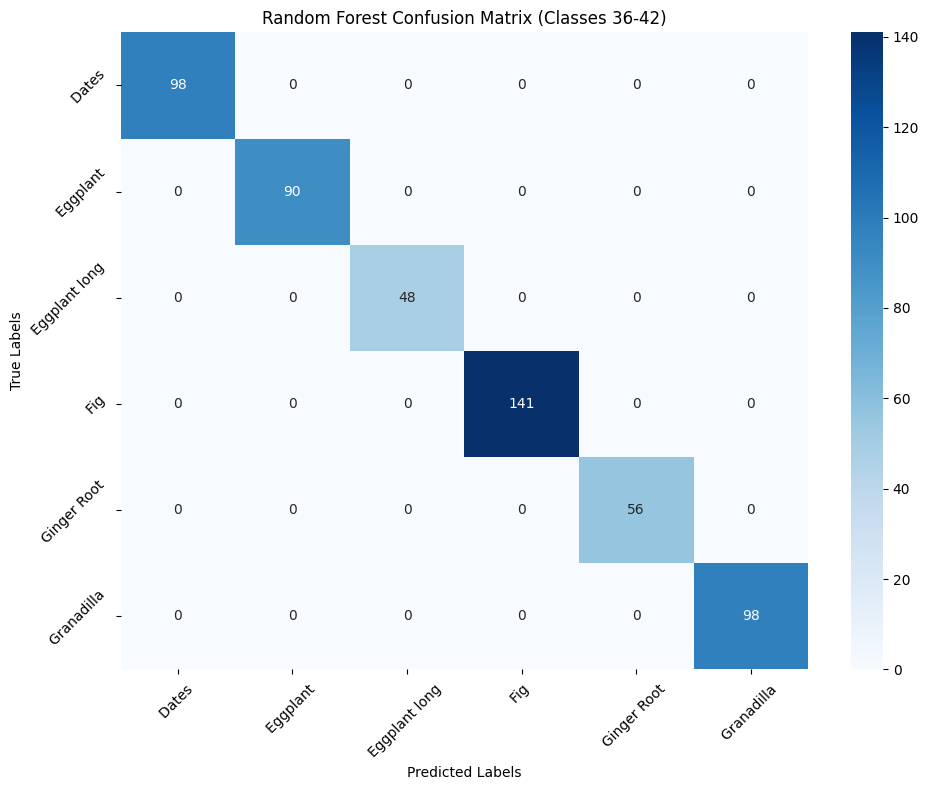

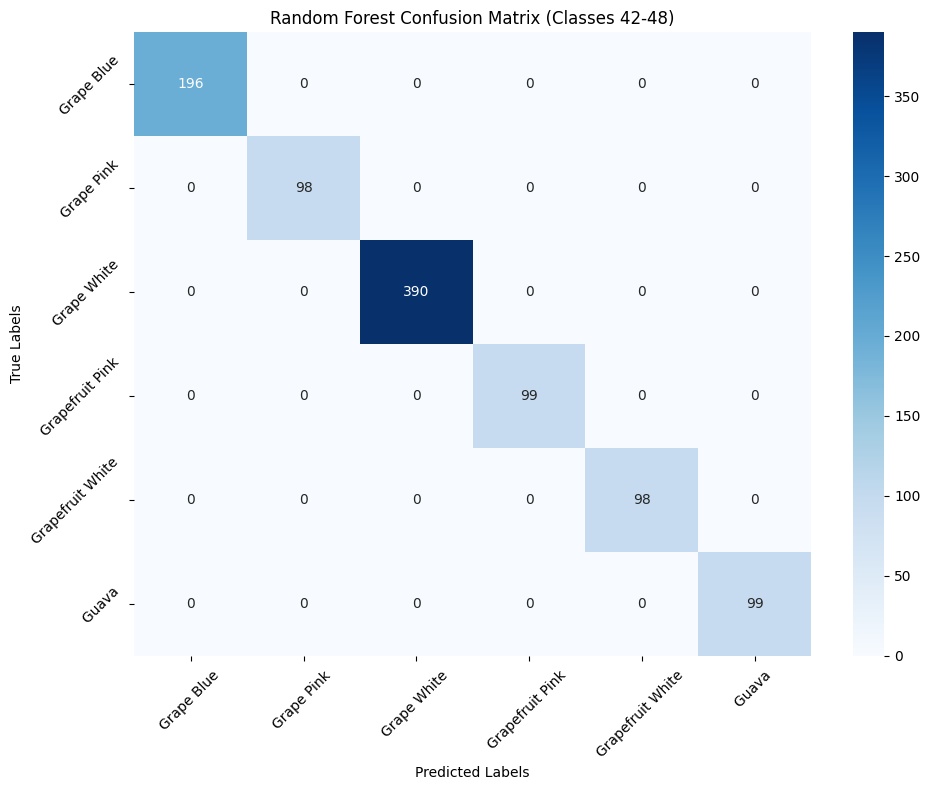

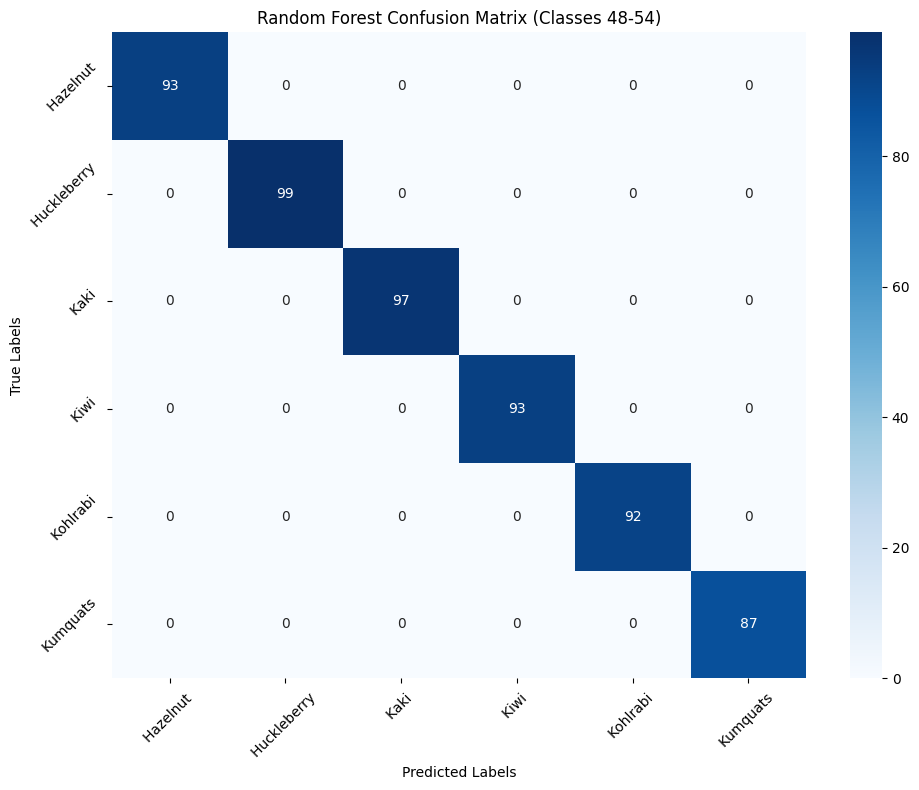

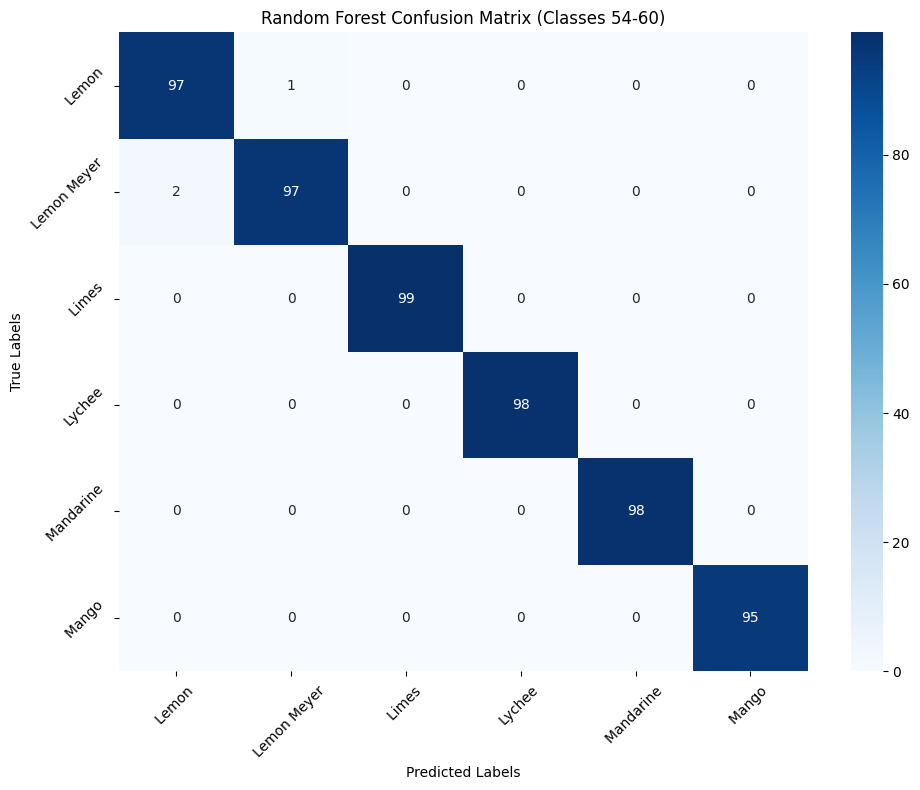

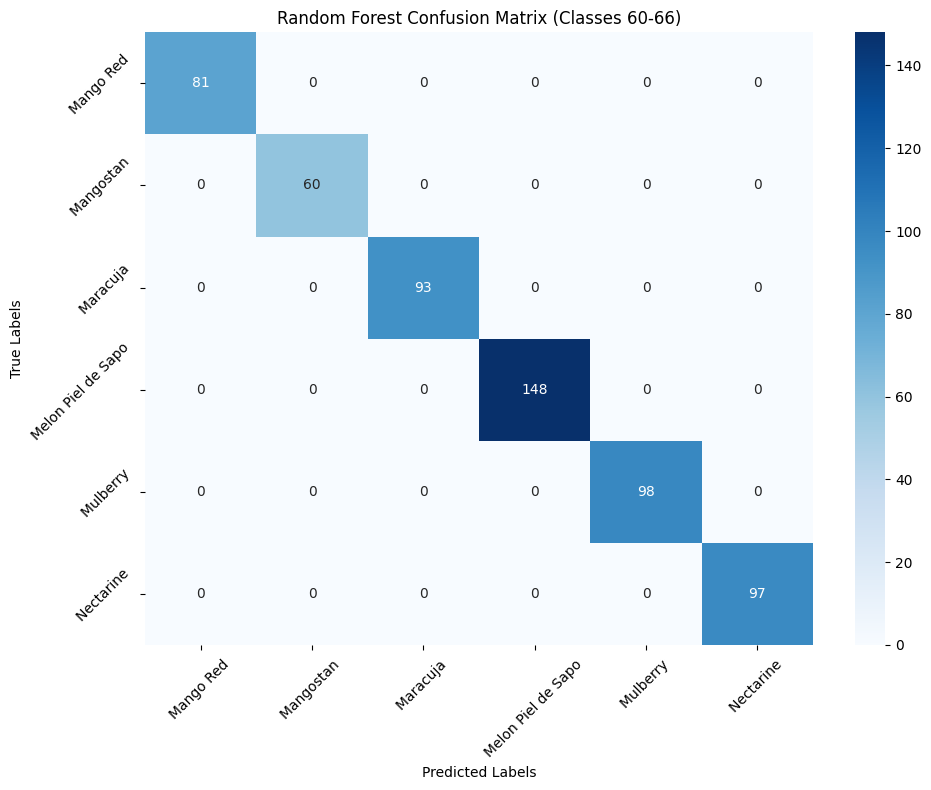

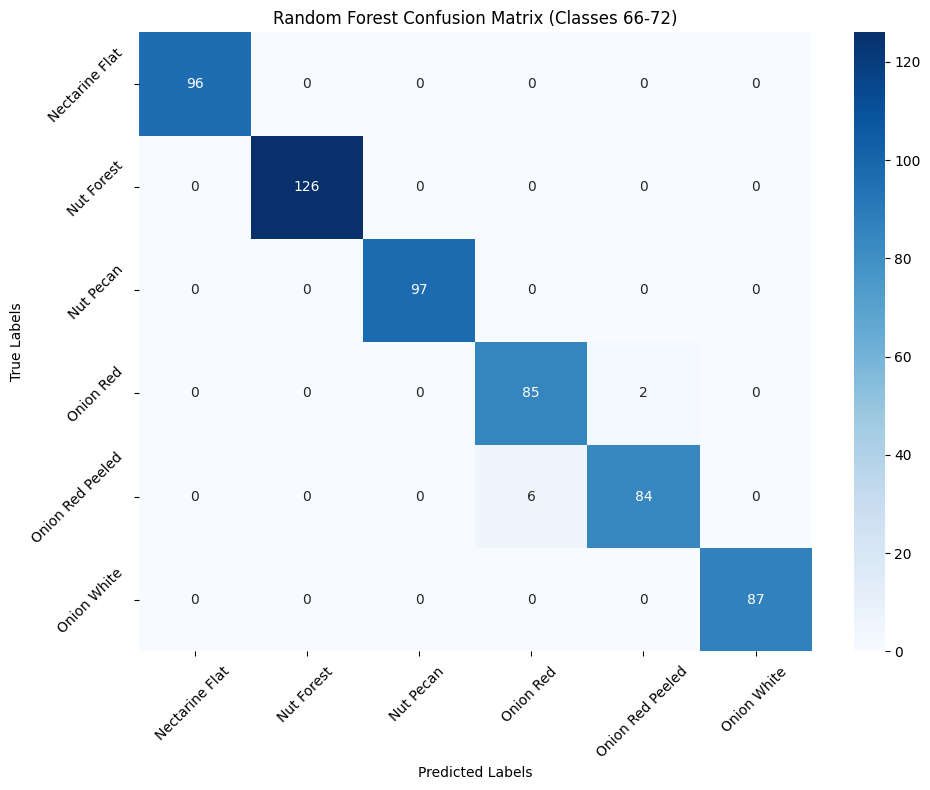

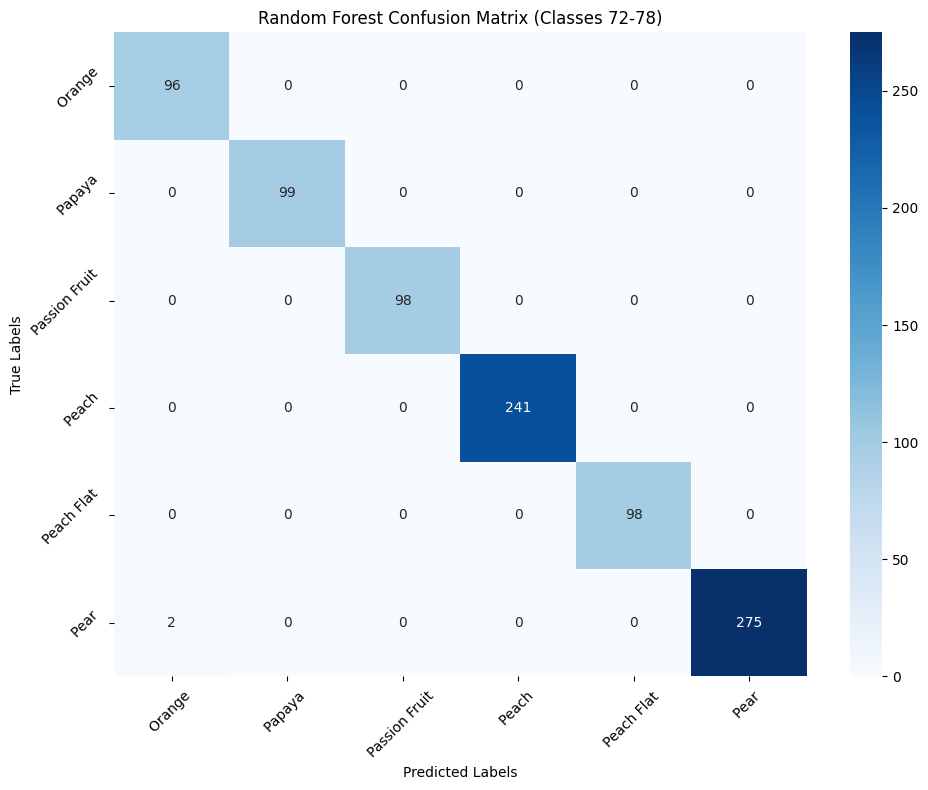

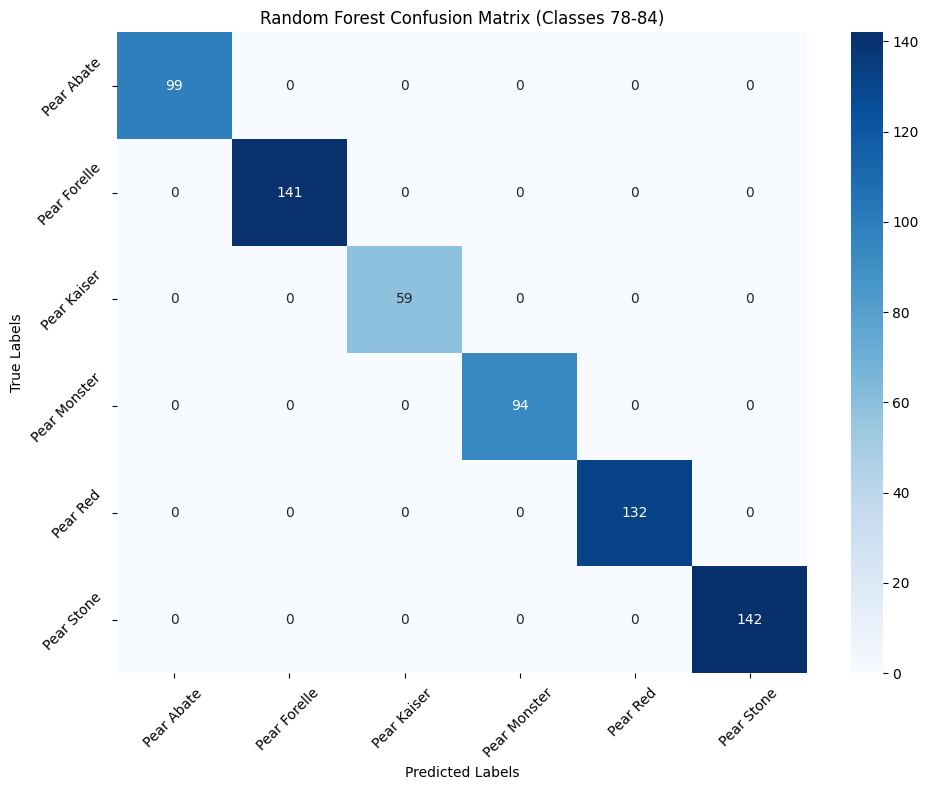

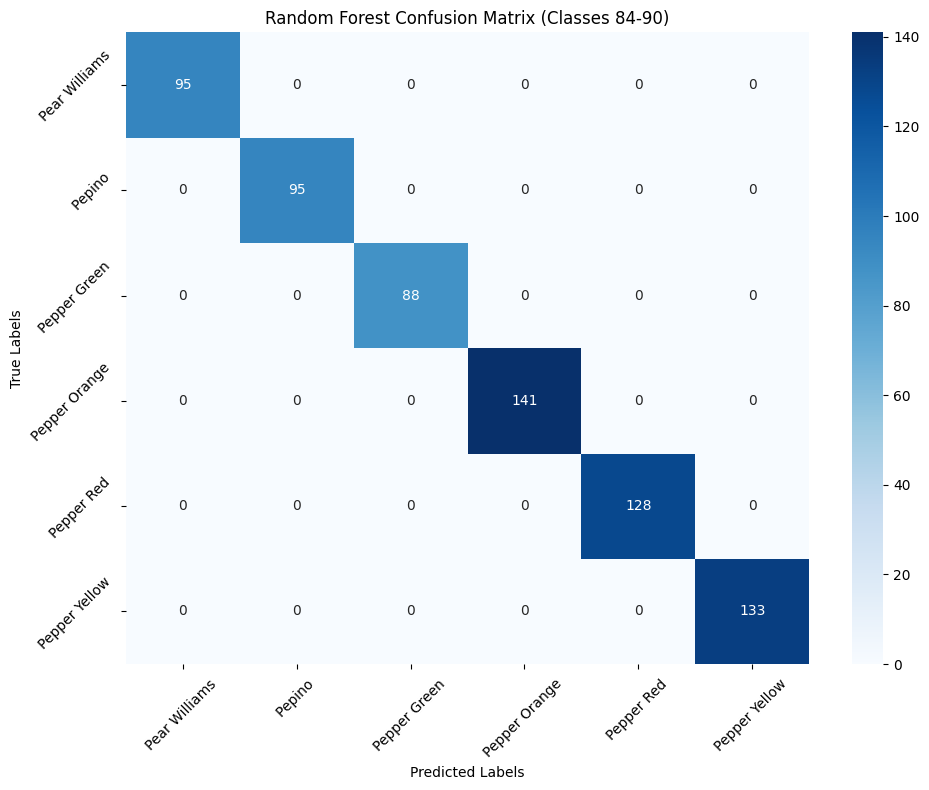

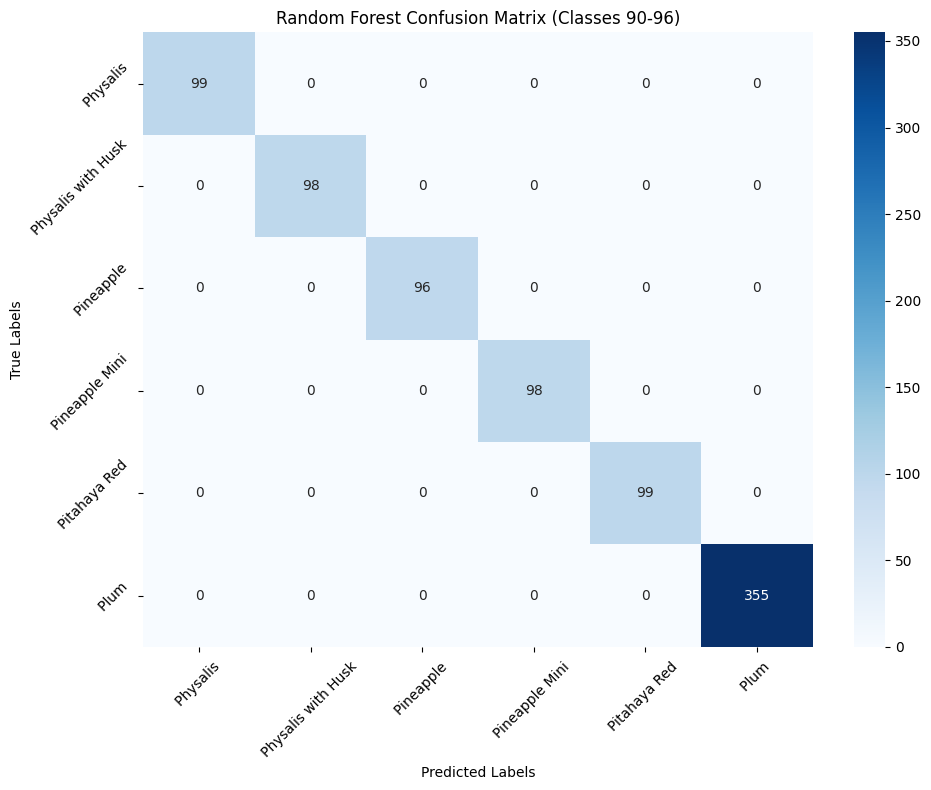

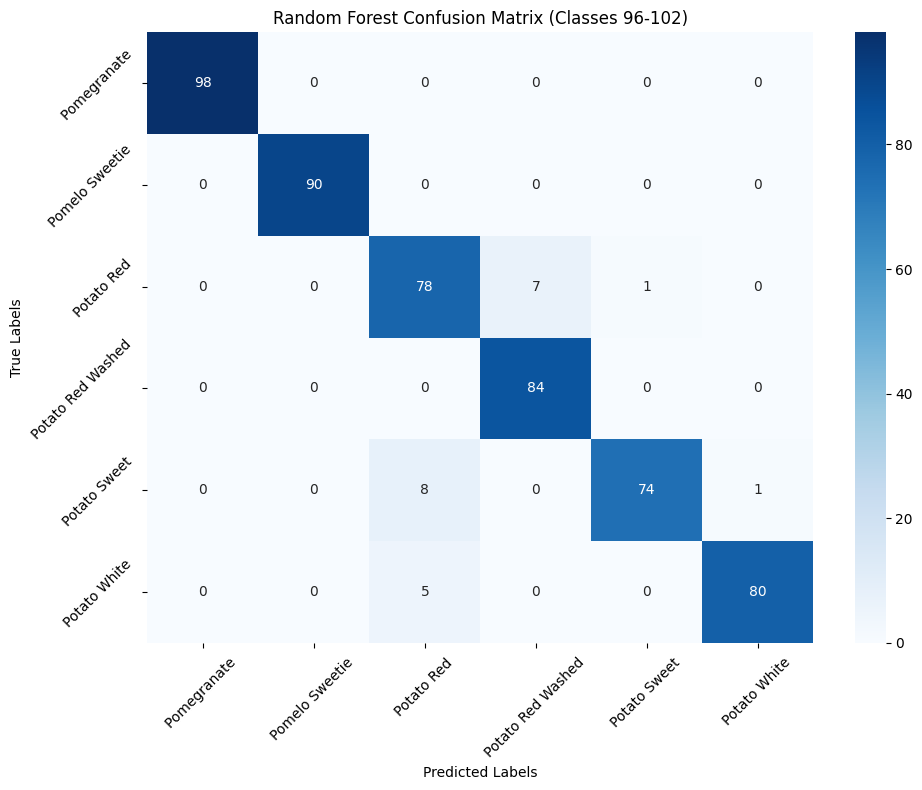

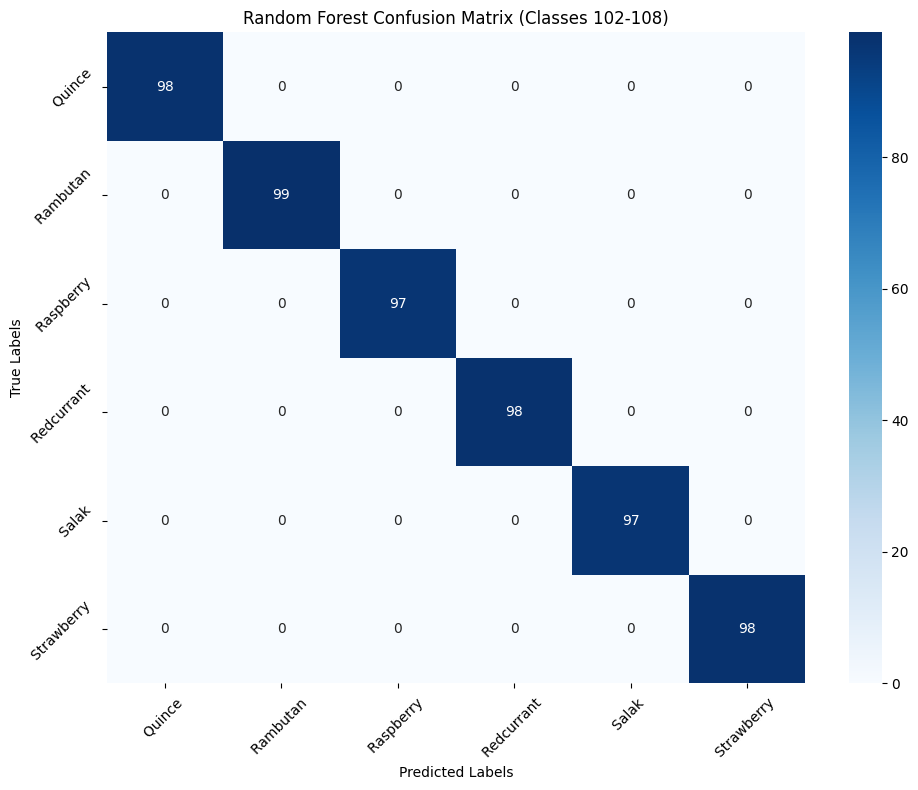

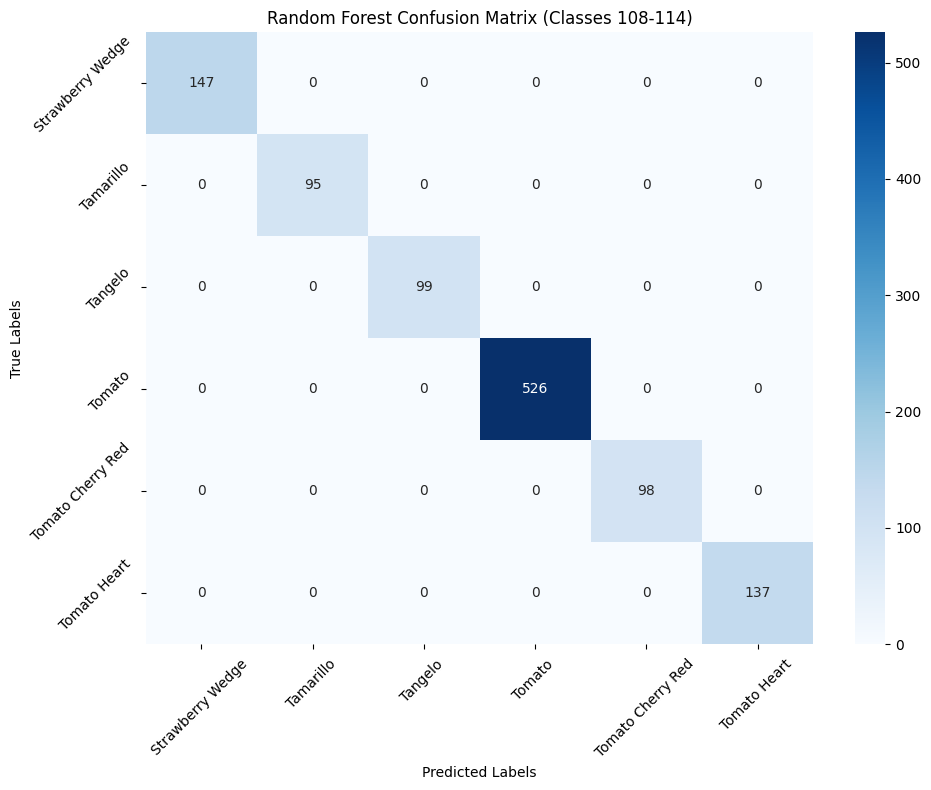

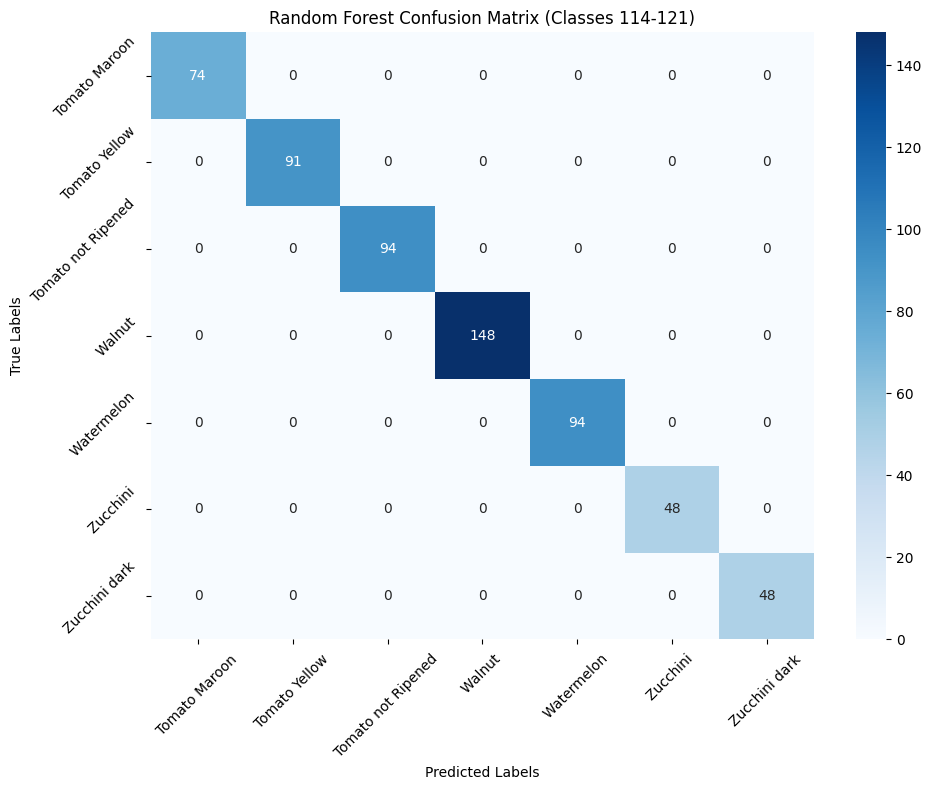

In [13]:
# Confusion Matrix hesaplama ve görselleştirme (Random Forest için)
confusion_matrix_rf = confusion_matrix(labels_test_encoded, predictions_test)

# 141 sınıfı 20 eşit parçaya bölme
num_classes = len(label_encoder.classes_)
group_size = num_classes // 20

for i in range(20):
    start = i * group_size
    end = start + group_size if i < 19 else num_classes
    partial_conf_matrix = confusion_matrix_rf[start:end, start:end]
    partial_classes = label_encoder.classes_[start:end]

    # Çizim
    plt.figure(figsize=(10, 8))
    sns.heatmap(partial_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=partial_classes, yticklabels=partial_classes)
    plt.title(f"Random Forest Confusion Matrix (Classes {start}-{end})")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
